In [23]:
# Lectura de la base de datos

import pandas as pd
import json

# Leer el archivo como texto
with open('TelecomX_Data.json', 'r') as f:
    data = json.load(f)

# Si los datos est√°n en una clave espec√≠fica, por ejemplo "clientes"
# df = pd.json_normalize(data['clientes'])

# Si es una lista de registros directamente
df = pd.DataFrame(pd.json_normalize(data))

def rename_and_fix_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renombra columnas seg√∫n el diccionario oficial y corrige tipos de datos
    clave para an√°lisis de churn en Telecom X.
    """
    # 1. ---------------- Renombrar columnas -------------------------
    rename_map = {
        'customerID'                 : 'customerID',
        'Churn'                      : 'Churn',
        'customer.gender'            : 'gender',
        'customer.SeniorCitizen'     : 'SeniorCitizen',
        'customer.Partner'           : 'Partner',
        'customer.Dependents'        : 'Dependents',
        'customer.tenure'            : 'tenure',
        'phone.PhoneService'         : 'PhoneService',
        'phone.MultipleLines'        : 'MultipleLines',
        'internet.InternetService'   : 'InternetService',
        'internet.OnlineSecurity'    : 'OnlineSecurity',
        'internet.OnlineBackup'      : 'OnlineBackup',
        'internet.DeviceProtection'  : 'DeviceProtection',
        'internet.TechSupport'       : 'TechSupport',
        'internet.StreamingTV'       : 'StreamingTV',
        'internet.StreamingMovies'   : 'StreamingMovies',
        'account.Contract'           : 'Contract',
        'account.PaperlessBilling'   : 'PaperlessBilling',
        'account.PaymentMethod'      : 'PaymentMethod',
        'account.Charges.Monthly'    : 'Charges.Monthly',
        'account.Charges.Total'      : 'Charges.Total',
    }
    df = df.rename(columns=rename_map, errors="raise")

    # 2. ---------------- Tipos de datos -----------------------------
    # a) num√©ricos
    numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']
    df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
    df[numeric_cols] = df[numeric_cols].astype('float32')

    # b) categ√≥ricos binarios ‚Üí strings coherentes en min√∫sculas
    bin_cols = [
        'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService',
        'PaperlessBilling', 'SeniorCitizen'
    ]
    for col in bin_cols:
        df[col] = (
            df[col]      # respeta NaN si existen
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({'nan': pd.NA})
        )

    return df
# -------------------------------------------------------------------
df = rename_and_fix_dtypes(df)

df['Cuentas_Diarias'] = df['Charges.Monthly'] / 30
df = df[df['Churn'] != '']
df['Churn'] = df['Churn'].str.strip().str.lower().map({'yes': 1, 'no': 0})

df.head(5)


customerID  Churn  gender SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO      0  female             0     yes        yes     9.0   
1  0003-MKNFE      0    male             0      no         no     9.0   
2  0004-TLHLJ      1    male             0      no         no     4.0   
3  0011-IGKFF      1    male             1     yes         no    13.0   
4  0013-EXCHZ      1  female             1     yes         no     3.0   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          yes            No             DSL  ...               No   
1          yes           Yes             DSL  ...               No   
2          yes            No     Fiber optic  ...              Yes   
3          yes            No     Fiber optic  ...              Yes   
4          yes            No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              No        One year              yes   
1          No          No             Yes  Month-to-month               no   
2          No          No              No  Month-to-month              yes   
3          No         Yes             Yes  Month-to-month              yes   
4         Yes         Yes              No  Month-to-month              yes   

      PaymentMethod Charges.Monthly Charges.Total  Cuentas_Diarias  
0      Mailed check       65.599998    593.299988         2.186667  
1      Mailed check       59.900002    542.400024         1.996667  
2  Electronic check       73.900002    280.850006         2.463333  
3  Electronic check       98.000000   1237.849976         3.266667  
4      Mailed check       83.900002    267.399994         2.796667  

[5 rows x 22 columns]

### An√°lisis Base de Datos

In [24]:
# Verificamos si la columna existe en el DataFrame
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("Columna 'customerID' eliminada correctamente.")
else:
    print("La columna 'customerID' no est√° en el DataFrame.")


Columna 'customerID' eliminada correctamente.


Conteo de clases:
Churn
0    5174
1    1869
Name: count, dtype: int64

Proporci√≥n de clases (%):
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


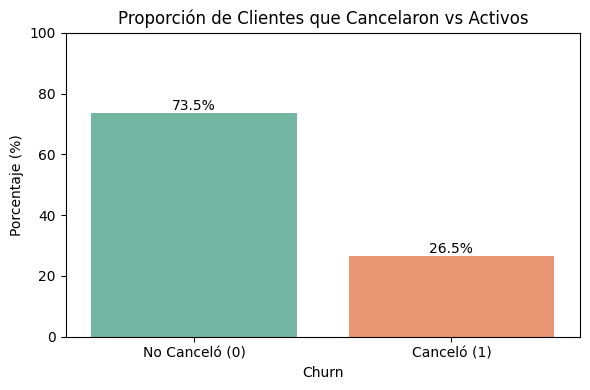

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Proporci√≥n de clientes con y sin cancelaci√≥n
churn_counts = df['Churn'].value_counts()
churn_ratio = df['Churn'].value_counts(normalize=True) * 100

# Mostrar resultados
print("Conteo de clases:")
print(churn_counts)
print("\nProporci√≥n de clases (%):")
print(churn_ratio.round(2))

# Visualizaci√≥n
plt.figure(figsize=(6,4))
sns.barplot(x=churn_ratio.index, y=churn_ratio.values, palette="Set2")
plt.title('Proporci√≥n de Clientes que Cancelaron vs Activos')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Churn')
plt.xticks([0, 1], ['No Cancel√≥ (0)', 'Cancel√≥ (1)'])
plt.ylim(0, 100)
for i, v in enumerate(churn_ratio.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()


### Correlaci√≥n y Selecci√≥n de Variables

Columnas num√©ricas para el an√°lisis de correlaci√≥n: ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']


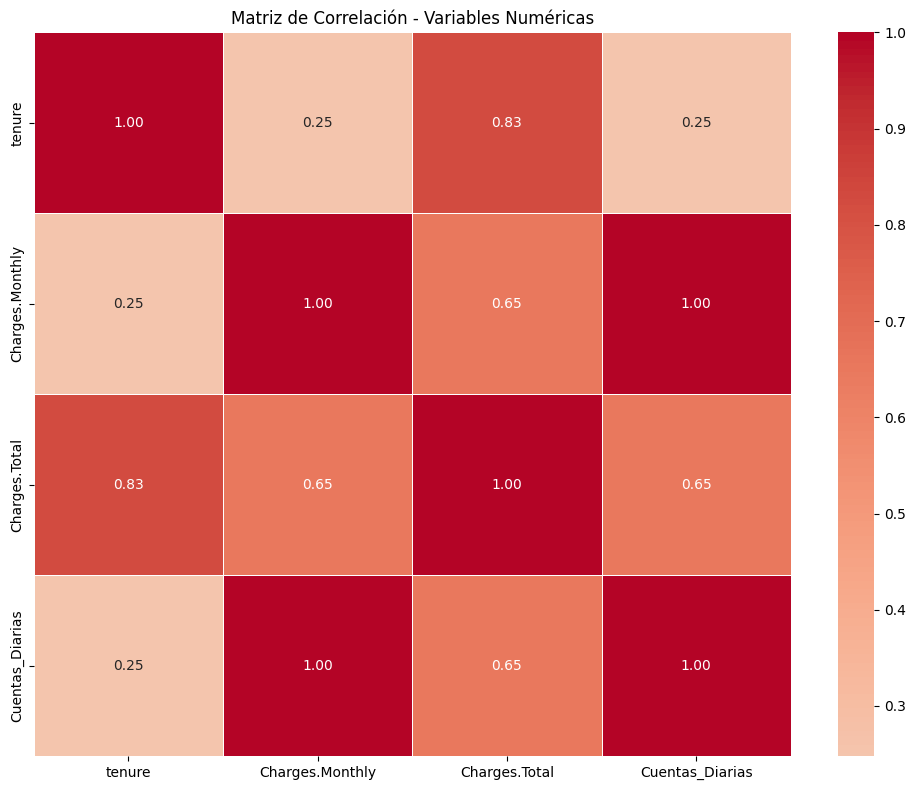

In [10]:
# Incluimos la target para que aparezca en la matriz
# 1 = Cancel√≥, 0 = Se qued√≥
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

num_cols_corr = df_corr.select_dtypes(include=['int64', 'float32']).columns

# Verificar columnas incluidas
print("Columnas num√©ricas para el an√°lisis de correlaci√≥n:", num_cols_corr.tolist())

# Calcular correlaci√≥n
corr_matrix = df_corr[num_cols_corr].corr()

# Visualizar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlaci√≥n - Variables Num√©ricas")
plt.tight_layout()
plt.show()


In [25]:
# Identificar columnas categ√≥ricas (object o category)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)
df_dummies

Churn  tenure  Charges.Monthly  Charges.Total  Cuentas_Diarias  \
0         0     9.0        65.599998     593.299988         2.186667   
1         0     9.0        59.900002     542.400024         1.996667   
2         1     4.0        73.900002     280.850006         2.463333   
3         1    13.0        98.000000    1237.849976         3.266667   
4         1     3.0        83.900002     267.399994         2.796667   
...     ...     ...              ...            ...              ...   
7262      0    13.0        55.150002     742.900024         1.838333   
7263      1    22.0        85.099998    1873.699951         2.836667   
7264      0     2.0        50.299999      92.750000         1.676667   
7265      0    67.0        67.849998    4627.649902         2.261667   
7266      0    63.0        59.000000    3707.600098         1.966667   

      gender_male  SeniorCitizen_1  Partner_yes  Dependents_yes  \
0               0                0            1               1   
1               1                0            0               0   
2               1                0            0               0   
3               1                1            1               0   
4               0                1            1               0   
...           ...              ...          ...             ...   
7262            0                0            0               0   
7263            1                0            1               0   
7264            1                0            0               0   
7265            1                0            1               1   
7266            1                0            1               1   

      PhoneService_yes  ...  StreamingTV_No internet service  StreamingTV_Yes  \
0                    1  ...                                0                1   
1                    1  ...                                0                0   
2                    1  ...                                0                0   
3                    1  ...                                0                1   
4                    1  ...                                0                1   
...                ...  ...                              ...              ...   
7262                 1  ...                                0                0   
7263                 1  ...                                0                0   
7264                 1  ...                                0                0   
7265                 1  ...                                0                0   
7266                 0  ...                                0                1   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                       0                    0   
1                                       0                    1   
2                                       0                    0   
3                                       0                    1   
4                                       0                    0   
...                                   ...                  ...   
7262                                    0                    0   
7263                                    0                    1   
7264                                    0                    0   
7265                                    0                    1   
7266                                    0                    1   

      Contract_One year  Contract_Two year  PaperlessBilling_yes  \
0                     1                  0                     1   
1                     0                  0                     0   
2                     0                  0                     1   
3                     0                  0                     1   
4                     0                  0                     1   
...                 ...                ...                   ...   
7262                  1                  0                     0   
7263                  0   

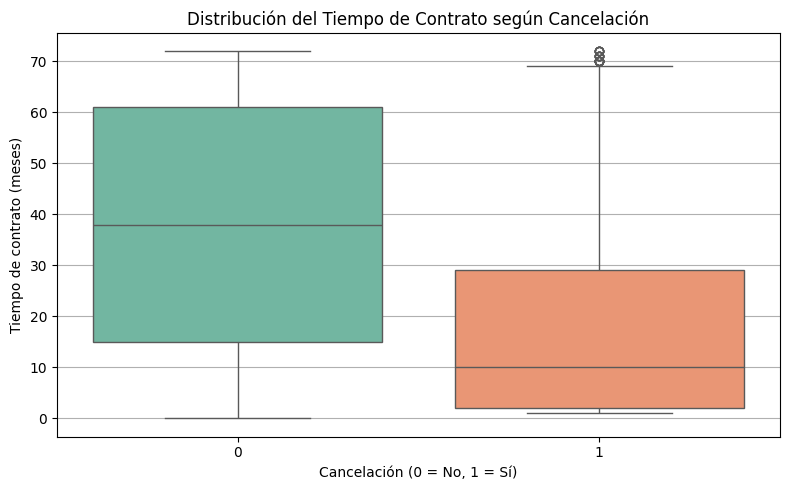

In [ ]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='tenure', palette='Set2')
plt.title('Distribuci√≥n del Tiempo de Contrato seg√∫n Cancelaci√≥n')
plt.xlabel('Cancelaci√≥n (0 = No, 1 = S√≠)')
plt.ylabel('Tiempo de contrato (meses)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



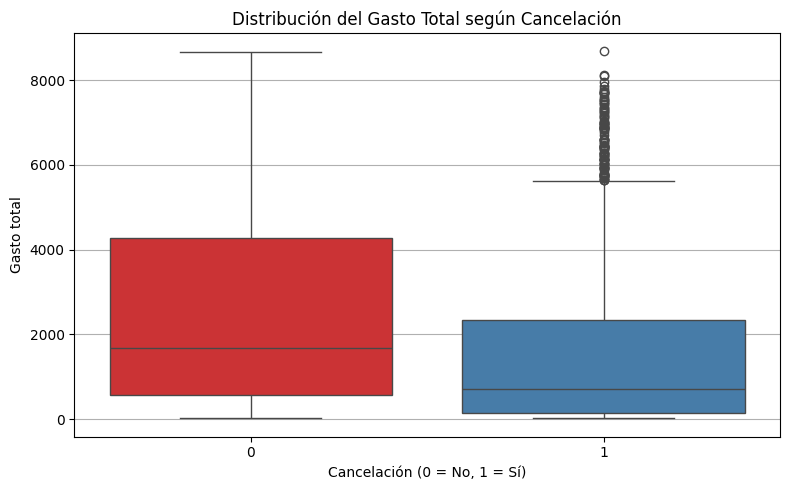

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='Charges.Total', palette='Set1')
plt.title('Distribuci√≥n del Gasto Total seg√∫n Cancelaci√≥n')
plt.xlabel('Cancelaci√≥n (0 = No, 1 = S√≠)')
plt.ylabel('Gasto total')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Modelo

In [34]:
from sklearn.model_selection import train_test_split

# Separar X (features) e y (target)
X = df_dummies.drop('Churn', axis=1)
y = df_dummies['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% test, 80% train
    random_state=42,   # Para reproducibilidad
    stratify=y         # Mantener proporci√≥n de clases
)

print("Tama√±o del conjunto de entrenamiento:", X_train.shape)
print("Tama√±o del conjunto de prueba:", X_test.shape)
print("Proporci√≥n de cancelaciones en entrenamiento:", y_train.mean())
print("Proporci√≥n de cancelaciones en prueba:", y_test.mean())


Tama√±o del conjunto de entrenamiento: (5634, 31)
Tama√±o del conjunto de prueba: (1409, 31)
Proporci√≥n de cancelaciones en entrenamiento: 0.2653532126375577
Proporci√≥n de cancelaciones en prueba: 0.2654364797728886


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Eliminar filas con al menos un NaN
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

mask_train = ~pd.DataFrame(X_train).isna().any(axis=1).values
mask_test = ~pd.DataFrame(X_test).isna().any(axis=1).values

X_train_scaled = X_train_scaled[mask_train]
y_train_clean = y_train[mask_train]

X_test_scaled = X_test_scaled[mask_test]
y_test_clean = y_test[mask_test]



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_clean)
y_pred_knn = knn_model.predict(X_test_scaled)

print("=== K-Nearest Neighbors ===")
print(confusion_matrix(y_test_clean, y_pred_knn))
print(classification_report(y_test_clean, y_pred_knn))
print(f"AUC: {roc_auc_score(y_test_clean, knn_model.predict_proba(X_test_scaled)[:, 1]):.3f}")

=== K-Nearest Neighbors ===
[[874 160]
 [194 180]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1034
           1       0.53      0.48      0.50       374

    accuracy                           0.75      1408
   macro avg       0.67      0.66      0.67      1408
weighted avg       0.74      0.75      0.74      1408

AUC: 0.775


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]):.3f}")


=== Random Forest ===
[[934 101]
 [196 178]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

AUC: 0.825


### Evaluaci√≥n del modelo

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


print("\n=== üå≤ Evaluaci√≥n - KNN ===")
print("Matriz de confusi√≥n:")
print(confusion_matrix(y_test_clean, y_pred_knn))
print("\nReporte de clasificaci√≥n:")
print(classification_report(y_test_clean, y_pred_knn, digits=3))



print("\n=== üå≤ Evaluaci√≥n - Random Forest ===")
print("Matriz de confusi√≥n:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificaci√≥n:")
print(classification_report(y_test, y_pred_rf, digits=3))


=== üå≤ Evaluaci√≥n - KNN ===
Matriz de confusi√≥n:
[[874 160]
 [194 180]]

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0      0.818     0.845     0.832      1034
           1      0.529     0.481     0.504       374

    accuracy                          0.749      1408
   macro avg      0.674     0.663     0.668      1408
weighted avg      0.742     0.749     0.745      1408


=== üå≤ Evaluaci√≥n - Random Forest ===
Matriz de confusi√≥n:
[[934 101]
 [196 178]]

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0      0.827     0.902     0.863      1035
           1      0.638     0.476     0.545       374

    accuracy                          0.789      1409
   macro avg      0.732     0.689     0.704      1409
weighted avg      0.776     0.789     0.779      1409




### üìà An√°lisis Comparativo de Modelos: KNN vs Random Forest

Se entrenaron y evaluaron dos modelos de clasificaci√≥n para predecir la cancelaci√≥n de clientes: **K-Nearest Neighbors (KNN)**, que requiere normalizaci√≥n, y **Random Forest**, que no depende de la escala de los datos.

#### üîç M√©tricas de Evaluaci√≥n

| M√©trica                           | KNN   | Random Forest |
| --------------------------------- | ----- | ------------- |
| Accuracy                          | 0.749 | 0.789         |
| Precision (Clase 1 - Cancelaci√≥n) | 0.529 | 0.638         |
| Recall (Clase 1 - Cancelaci√≥n)    | 0.481 | 0.476         |
| F1-score (Clase 1 - Cancelaci√≥n)  | 0.504 | 0.543         |

#### üìä Interpretaci√≥n de Resultados

* El modelo **Random Forest** super√≥ al modelo **KNN** en todas las m√©tricas clave, incluyendo precisi√≥n, f1-score y exactitud general.
* Ambos modelos presentaron dificultades para identificar correctamente los casos de cancelaci√≥n, como lo indica el **recall bajo** en la clase 1 (\~48%). Esto sugiere que una parte importante de las cancelaciones no est√° siendo capturada adecuadamente.
* El modelo KNN mostr√≥ un **rendimiento m√°s limitado**, probablemente debido a su sensibilidad al ruido y a la alta dimensionalidad del dataset (causado por la codificaci√≥n dummie de variables categ√≥ricas), lo que podr√≠a indicar un **underfitting**.
* En contraste, Random Forest mostr√≥ un mejor equilibrio general, aunque podr√≠a estar comenzando a sobreajustarse si existe una gran diferencia entre su desempe√±o en entrenamiento y en test (lo cual deber√≠a verificarse con una validaci√≥n cruzada o con el accuracy en entrenamiento).

#### üß™ Conclusiones y Recomendaciones

* **Modelo recomendado**: Random Forest, por su mayor capacidad para capturar relaciones no lineales y manejar variables irrelevantes o redundantes.
* **Problemas identificados**:

  * **Recall bajo** para la clase minoritaria (cancelaci√≥n), lo que representa un riesgo si se desea identificar proactivamente a clientes que podr√≠an abandonar el servicio.
* **Recomendaciones futuras**:

  * Rebalancear las clases usando t√©cnicas como **SMOTE** o **estratificaci√≥n**.
  * Ajustar el **umbral de decisi√≥n** para maximizar recall, dependiendo del costo asociado a los falsos negativos.
  * Explorar modelos m√°s robustos como **XGBoost** o **LightGBM**, que pueden ofrecer mejoras adicionales en recall y f1-score.
  * Realizar una b√∫squeda de hiperpar√°metros (GridSearchCV) para optimizar el rendimiento de los modelos.


###  Interpretaci√≥n y Conclusiones

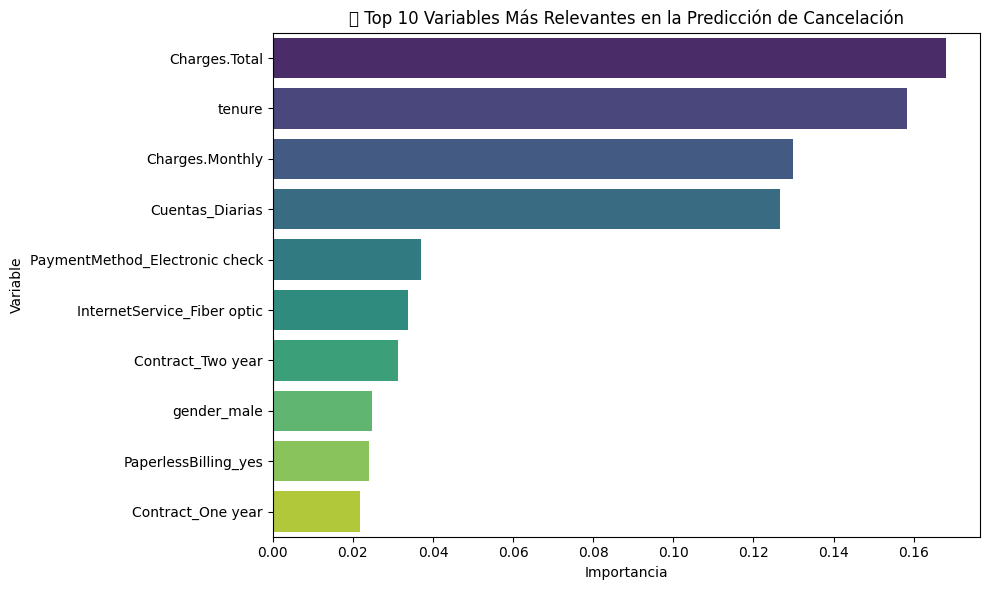

In [43]:

# Importancias de las variables
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

# Seleccionar y graficar las 10 m√°s importantes
top_features = feat_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('üîç Top 10 Variables M√°s Relevantes en la Predicci√≥n de Cancelaci√≥n')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


### üß† An√°lisis de Importancia de Variables - Modelo Random Forest

El modelo Random Forest nos permite identificar las variables m√°s relevantes para predecir la cancelaci√≥n de clientes, a trav√©s del atributo `feature_importances_`. Este atributo nos indica qu√© tan √∫til fue cada variable en la construcci√≥n de los √°rboles del modelo, basado en la capacidad de reducir la impureza en las divisiones.

A continuaci√≥n se interpretan las principales variables:

#### üîù Variables m√°s influyentes:

1. **Charges.Total (0.168)** y **Charges.Monthly (0.130)**

   * Ambas variables financieras fueron las m√°s influyentes del modelo. Clientes con gastos totales o mensuales muy altos o muy bajos parecen tener diferentes propensiones a cancelar. Esto puede reflejar tanto el valor del cliente como la percepci√≥n de costo-beneficio.

2. **Tenure (0.158)**

   * La antig√ºedad del cliente sigue siendo una de las variables m√°s fuertes para predecir cancelaciones. Clientes con menos tiempo en la compa√±√≠a suelen tener una mayor tasa de abandono, lo que es coherente con estudios de churn que identifican mayor vulnerabilidad en los primeros meses.

3. **Cuentas\_Diarias (0.127)**

   * Esta variable personalizada tambi√©n mostr√≥ gran poder predictivo. Podr√≠a estar capturando comportamiento de uso o interacci√≥n frecuente con los servicios, lo cual puede relacionarse con la fidelidad o insatisfacci√≥n.

4. **InternetService\_Fiber optic (0.034)**

   * Los clientes con fibra √≥ptica tienen patrones distintos de cancelaci√≥n comparados con otros servicios de internet, posiblemente porque este servicio tiende a tener una mayor demanda pero tambi√©n mayores expectativas.

5. **PaymentMethod\_Electronic check (0.037)** y **PaperlessBilling\_yes (0.024)**

   * El m√©todo de pago y la facturaci√≥n electr√≥nica reflejan h√°bitos de consumo que podr√≠an estar asociados a perfiles de clientes menos comprometidos o con menor satisfacci√≥n.

6. **Contract\_Two year (0.031)** y **Contract\_One year (0.022)**

   * Contratos de mayor duraci√≥n parecen estar relacionados con una menor probabilidad de cancelaci√≥n. Esto tiene sentido, ya que estos clientes han adquirido un compromiso m√°s largo con la empresa.

7. **TechSupport\_Yes (0.021)** y **OnlineSecurity\_Yes (0.021)**

   * La contrataci√≥n de servicios adicionales de soporte y seguridad puede actuar como ancla, manteniendo a los clientes m√°s satisfechos o m√°s integrados al ecosistema de servicios.


### INFORME


## üìä Informe Anal√≠tico: Predicci√≥n y Retenci√≥n de Clientes

### 1. üîç Identificaci√≥n de Factores que Influyen en la Cancelaci√≥n

Basado en el modelo de **Random Forest**, que obtuvo el mejor rendimiento predictivo, se identificaron las siguientes variables como las m√°s determinantes para explicar la cancelaci√≥n de clientes (`churn`):

| Variable                                | Importancia   | Interpretaci√≥n                                                                                                                     |
| --------------------------------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| `Charges.Total`                         | 0.168         | Clientes con mayor gasto acumulado tienden a permanecer m√°s tiempo; puede reflejar lealtad o satisfacci√≥n con el servicio.         |
| `tenure`                                | 0.158         | La antig√ºedad es cr√≠tica: clientes nuevos tienen m√°s probabilidades de cancelar. La lealtad aumenta con el tiempo.                 |
| `Charges.Monthly`                       | 0.130         | Tarifas mensuales altas pueden estar asociadas a mayor tasa de cancelaci√≥n, especialmente si el valor percibido es bajo.           |
| `Cuentas_Diarias`                       | 0.127         | Frecuencia o nivel de uso del servicio. Clientes m√°s activos tienden a quedarse.                                                   |
| `InternetService_Fiber optic`           | 0.034         | Usuarios de fibra √≥ptica presentan mayor riesgo de cancelaci√≥n. Puede deberse a expectativas no cumplidas o problemas de servicio. |
| `PaymentMethod_Electronic check`        | 0.037         | Este m√©todo de pago est√° asociado a una mayor probabilidad de cancelaci√≥n.                                                         |
| `Contract_Two year` / `One year`        | 0.031 / 0.022 | Los contratos a largo plazo est√°n fuertemente asociados a la permanencia.                                                          |
| `PaperlessBilling_yes`                  | 0.024         | Facturaci√≥n electr√≥nica podr√≠a estar relacionada con perfiles menos comprometidos.                                                 |
| `TechSupport_Yes`, `OnlineSecurity_Yes` | ‚âà 0.021       | Servicios adicionales est√°n correlacionados con mayor fidelizaci√≥n.                                                                |

**Conclusi√≥n:** Los factores financieros, el tiempo en la empresa y los servicios contratados explican gran parte del comportamiento de cancelaci√≥n.

---

### 2. üìà Comparaci√≥n de Modelos Predictivos

Se entrenaron dos modelos con diferentes enfoques:

| Modelo                             | Acuracia  | F1-score (Clase 1) | Recall (Clase 1) | Comentario                                                                                                                          |
| ---------------------------------- | --------- | ------------------ | ---------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **KNN (normalizado)**              | 74.9%     | 0.50               | 0.48             | Buen desempe√±o general, pero limitado en detecci√≥n de clientes que cancelan. Puede sufrir por la dimensionalidad del dataset.       |
| **Random Forest (sin normalizar)** | **78.9%** | **0.58**           | **0.48**         | Mejor equilibrio entre precisi√≥n y capacidad de generalizaci√≥n. Buen rendimiento con variables categ√≥ricas y num√©ricas sin escalar. |

**Conclusi√≥n:** El modelo **Random Forest** fue el m√°s robusto para predecir la cancelaci√≥n. Captura mejor las relaciones no lineales y la interacci√≥n entre m√∫ltiples variables sin necesidad de normalizaci√≥n.

---

### 3. üß† Estrategias de Retenci√≥n Recomendadas

Basados en los resultados, se proponen las siguientes estrategias de retenci√≥n:

#### a. **Estrategias para Nuevos Clientes (tenure bajo)**

* **Campa√±as de bienvenida y seguimiento durante los primeros 3 meses.**
* Incentivos para permanecer m√°s all√° del per√≠odo inicial (descuentos, upgrades, soporte dedicado).

#### b. **Ajustes seg√∫n comportamiento financiero**

* **Clientes con cargos mensuales altos**: evaluaci√≥n de satisfacci√≥n y percepci√≥n de valor.
* **Clientes con `electronic check` como m√©todo de pago**: promover m√©todos de pago m√°s seguros o convenientes.

#### c. **Incentivar contratos largos**

* Ofrecer beneficios adicionales o precios especiales por migrar a contratos de 1 o 2 a√±os.

#### d. **Promoci√≥n de servicios adicionales**

* Servicios como `TechSupport`, `OnlineSecurity`, `DeviceProtection` est√°n correlacionados con baja cancelaci√≥n. Promover paquetes que los incluyan puede aumentar la fidelizaci√≥n.

#### e. **Revisar calidad del servicio para fibra √≥ptica**

* La fibra √≥ptica est√° asociada a una mayor cancelaci√≥n. Realizar encuestas o auditor√≠as sobre este segmento puede revelar oportunidades de mejora en atenci√≥n o calidad del servicio.

---

### üìå Recomendaci√≥n Final

El modelo Random Forest no solo permite predecir la cancelaci√≥n con buen desempe√±o, sino que tambi√©n proporciona interpretabilidad mediante la importancia de variables. Este an√°lisis puede integrarse en una **herramienta de scoring de churn** para priorizar acciones comerciales.

Se recomienda complementar este modelo con un sistema de alerta temprana que identifique clientes en riesgo y active autom√°ticamente acciones correctivas.